<a href="https://colab.research.google.com/github/rahmansadiqgit/Thesis_Work/blob/master/xgboost2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("hasibur013/phishing-data")

Using Colab cache for faster access to the 'phishing-data' dataset.


In [2]:
!ls $path

PhishingData.csv


In [3]:
path

'/kaggle/input/phishing-data'

# **DATASET 3, XGBoost model 2**

In [4]:
import pandas as pd
df2 = pd.read_csv(path+"/PhishingData.csv")

In [5]:
df2.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


# 1) url_features.py

In [6]:
# url_features.py
import re
import socket
from urllib.parse import urlparse

def extract_url_features(url):
    parsed = urlparse(url)
    hostname = parsed.hostname if parsed.hostname else ""

    features = {}


    # 1. IP Address Check
    try:
        socket.inet_aton(hostname)
        features["having_IPhaving_IP_Address"] = 1
    except:
        features["having_IPhaving_IP_Address"] = -1

    # 2. URL Length
    features["URLURL_Length"] = 1 if len(url) < 54 else -1

    # 3. Shortening Service
    shorteners = r"(bit\.ly|goo\.gl|tinyurl|shorte\.st|is\.gd|buff\.ly|adf\.ly)"
    features["Shortining_Service"] = -1 if re.search(shorteners, url) else 1

    # 4. @ Symbol
    features["having_At_Symbol"] = -1 if "@" in url else 1

    # 5. Extra //
    features["double_slash_redirecting"] = -1 if "//" in url[7:] else 1

    # 6. Prefix/Suffix
    features["Prefix_Suffix"] = -1 if "-" in hostname else 1

    # 7. Subdomain
    features["having_Sub_Domain"] = -1 if hostname.count(".") >= 3 else 1

    # 8. SSLfinal_State (URL only version)
    features["SSLfinal_State"] = 1 if url.startswith("https") else -1

    # 9. HTTPS Token inside domain
    features["HTTPS_token"] = -1 if "https" in hostname else 1

    return features


# 3) html_features

In [7]:
# html_features.py
import re
import requests
from bs4 import BeautifulSoup

def safe_request(url):
    try:
        r = requests.get(url, timeout=5, headers={'User-Agent': 'Mozilla/5.0'})
        if r.status_code == 200:
            return r.text
    except:
        pass
    return None

def extract_html_features(url, domain):
    html = safe_request(url)
    features = {}

    if html is None:
        # HTML-dependent features default to -1
        html_features = [
            "Favicon", "port", "Request_URL", "URL_of_Anchor",
            "Links_in_tags", "SFH", "Submitting_to_email",
            "Abnormal_URL", "Redirect", "on_mouseover",
            "RightClick", "popUpWidnow", "Iframe", "DNSRecord"
        ]
        for f in html_features:
            features[f] = -1
        return features

    soup = BeautifulSoup(html, "lxml")
    features["DNSRecord"] = 1

    # Favicon
    features["Favicon"] = 1 if soup.find("link", rel=lambda x: x and "icon" in x.lower()) else -1

    # External images (Request_URL)
    images = soup.find_all("img")
    if images:
        external = sum(1 for i in images if i.get("src") and domain not in i.get("src"))
        features["Request_URL"] = -1 if external / len(images) > 0.5 else 1
    else:
        features["Request_URL"] = 1

    # Anchor tags
    anchors = soup.find_all("a")
    if anchors:
        suspicious = sum(1 for a in anchors if a.get("href") in ["", "#"] or "javascript" in str(a.get("href")))
        features["URL_of_Anchor"] = -1 if suspicious / len(anchors) > 0.5 else 1
    else:
        features["URL_of_Anchor"] = 1

    # Meta/script/link external
    tags = soup.find_all(["meta", "script", "link"])
    if tags:
        suspicious = sum(1 for t in tags if (t.get("src") and domain not in t.get("src")) or (t.get("href") and domain not in t.get("href")))
        features["Links_in_tags"] = -1 if suspicious / len(tags) > 0.5 else 1
    else:
        features["Links_in_tags"] = 1

    # SFH
    forms = soup.find_all("form")
    sfh_flag = 1
    for f in forms:
        action = f.get("action", "")
        if action == "" or "about:blank" in action:
            sfh_flag = -1
            break
    features["SFH"] = sfh_flag

    # Email submission
    features["Submitting_to_email"] = -1 if "mailto:" in html else 1

    # Abnormal URL
    features["Abnormal_URL"] = -1 if domain not in html else 1

    # Redirects
    features["Redirect"] = -1 if len(re.findall(r"window\.location", html)) > 2 else 1

    # Mouseover script
    features["on_mouseover"] = -1 if "onmouseover=" in html else 1

    # Right-click block
    features["RightClick"] = -1 if "event.button==2" in html else 1

    # Popup
    features["popUpWidnow"] = -1 if "alert(" in html else 1

    # Iframe
    features["Iframe"] = -1 if soup.find("iframe") else 1

    # Port (simplified)
    features["port"] = 1

    return features


In [8]:
from urllib.parse import urlparse
from collections import OrderedDict

def extract_features(url):
    parsed = urlparse(url)
    domain = parsed.hostname or ""

    data = OrderedDict()  # ensures consistent order

    # Make sure these functions exist and return dictionaries
    data.update(extract_url_features(url))
    # data.update(extract_whois_features(domain))
    data.update(extract_html_features(url, domain))

    return data


In [9]:

FEATURE_LIST = list(extract_features("www.facebook.com").keys())


# **train by XGBoost Model2**#

In [10]:
df2.columns = df2.columns.str.strip()


In [11]:
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split

X = df2[FEATURE_LIST]
y = df2['Result'].replace(-1, 0)
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )


# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'binary:logistic',
    'max_depth': 7,
    'eta': 0.07,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'eval_metric': 'logloss'
}

evals = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    callbacks=[EarlyStopping(rounds=50, save_best=True)],
    verbose_eval=False
)


#Evalution Function

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def xgboost2_Evaluation(urls, labels):
    # Extract features for each URL
    records = [extract_features(url) for url in urls]
    X_test = pd.DataFrame(records, columns=FEATURE_LIST)

    # Convert to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Predict using xgboost model
    pred_y = bst.predict(dtest)

    # Convert probability to class (0/1)
    pred_y = (pred_y >= 0.5).astype(int)
    pred_y = pd.Series(pred_y)

    # Convert labels to Series
    labels = pd.Series(labels)

    # Accuracy
    accuracy = accuracy_score(labels, pred_y)
    print("Accuracy:", accuracy)

    # -------- Confusion Matrix --------
    cm = confusion_matrix(labels, pred_y)

    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Text inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')

    plt.colorbar()
    plt.show()


#Own model has no url .. so url extraction not possible..

# Testing by Phishing Websites Detection

In [ ]:
import kagglehub
path = kagglehub.dataset_download("akshaya1508/phishing-websites-detection")

Using Colab cache for faster access to the 'phishing-websites-detection' dataset.


In [ ]:
import pandas as pd
new_df = pd.read_excel(path+"/Detection.xlsx")


In [ ]:
new_df['Result'] = new_df['Result'].replace(-1, 0)

new_df.URL.head()


,URL
0,https://pogodasub.com/2Ge6I0rd/4p0OksK6-inteli...
1,https://pogodasub.com/2Ge6I0rd/Ly6I98Se-ipko/l...
2,https://pogodasub.com/2Ge6I0rd/hz6hZnA
3,https://resicorphome.com/brian/srr/austin/
4,https://kurier24-oplata.com/PzVxLK7l/WdJslUDi-...


In [ ]:
new_df.columns

Index(['URL', 'Having @ Symbol', 'Presence of IP Address', 'Length of URL',
       'No. of Slashes', 'Special Character', 'No.of Dots',
       'No. of Hyphen in Host Address', '"Email" Keyword', 'TLS ',
       'Age of URL', 'Result'],
      dtype='object')

## Testing

Accuracy: 0.5614285714285714


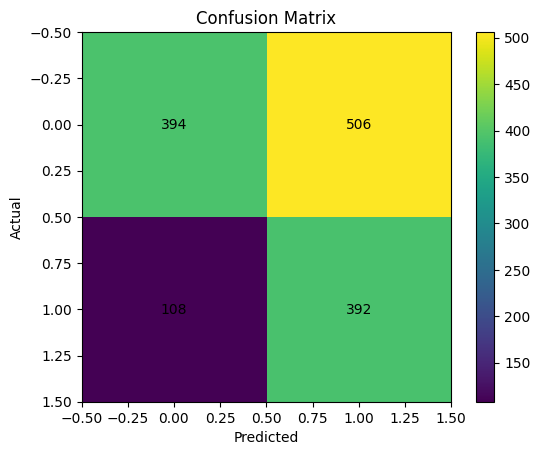

In [ ]:
xgboost2_predict(new_df.URL.head(10000) , new_df.Result.head(10000))

# Testing by XGBoost1 DataSet

In [ ]:
import kagglehub
path = kagglehub.dataset_download("saqibgulzarbhat/uci-phishing-detection-dataset")

Using Colab cache for faster access to the 'uci-phishing-detection-dataset' dataset.


In [ ]:
import pandas as pd
XG1_df = pd.read_csv(path+'/PhiUSIIL_Phishing_URL_Dataset.csv')

## Testing

/tmp/ipython-input-2681465185.py:31: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(html, "lxml")


Accuracy: 0.87


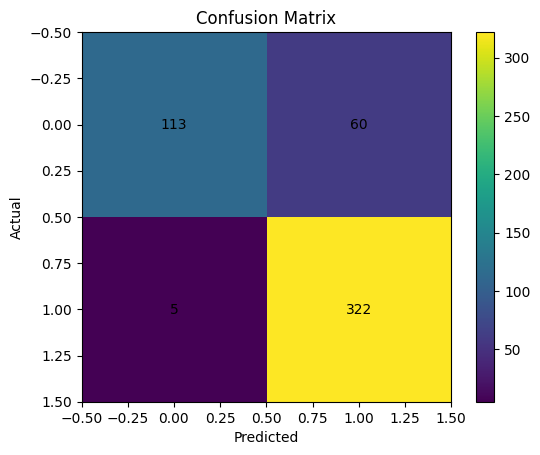

In [ ]:
xgboost2_predict(XG1_df.URL.head(500) , XG1_df.label.head(500))

# Manual Test by ChatGpt

In [ ]:
test_urls = [
    "https://www.google.com",
    "https://www.facebook.com",
    "https://www.amazon.com",
    "https://www.microsoft.com",
    "https://www.netflix.com",
    "https://www.github.com",
    "https://www.twitter.com",
    "https://www.wikipedia.org",
    "https://www.apple.com",
    "https://www.stackoverflow.com",
    "http://secure-login-paypal.com.verify-user-info.cc/login",
    "http://bankofamerica.secure-alerts-update.net/account",
    "https://facebook.com.security-check-verify.ga/login",
    "http://amazon-login-support-refund.co/account/verify",
    "https://gmail.com.recovery-support-team.ml/verify",
    "http://microsoft-update-security-center.info/login",
    "https://appleid-login-auth-service.ru/secure",
    "http://dropbox-file-share-download.xyz/secure-login",
    "https://netflix-billing-update-support.tk/confirm",
    "http://icici-bank-update-alerts.online/login"
]

test_y = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,0,0,0,0,0,0,0,0,0,0]


Accuracy: 1.0


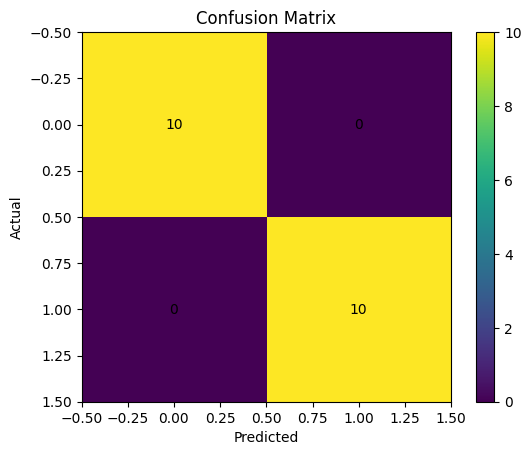

In [ ]:
xgboost2_predict(test_urls, test_y)

# CHecking by chathpt 5000 generated url

In [13]:
from google.colab import files

uploaded = files.upload()


Saving url_dataset_5000.csv to url_dataset_5000 (1).csv


In [15]:
CG_df = pd.read_csv("url_dataset_5000.csv")

In [16]:
CG_df["label"] = CG_df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-277365720.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CG_df["label"] = CG_df["label"].replace({


In [17]:
CG_df.head()

,url,label
0,https://mcrravlgw.info/login/ileh?redirect=gep...,0
1,https://aghlsktp.app/nargwy/eoadkkhikp,1
2,https://lmpcfqmgc.net/bvlh%25wur%25fz%25sfyh/w...,0
3,https://ncnk.co/login/flhfb?redirect=qjkc,0
4,http://iamzr.io/bdqv/duyq/qyqmeusxpp?page=jQw7...,1


Accuracy: 0.5814


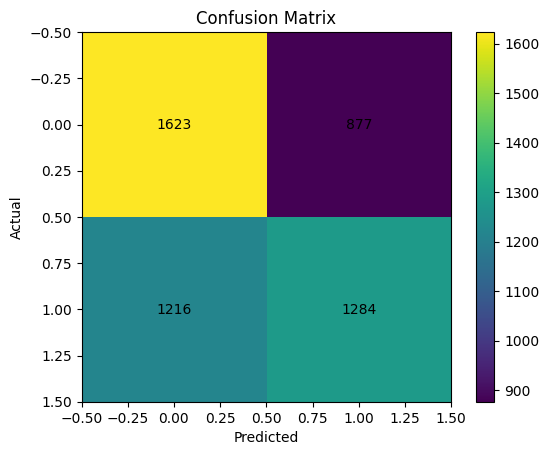

In [20]:
xgboost2_predict(CG_df.url, CG_df.label)

# Checking by Claude 5000 urls

In [21]:
from google.colab import files

uploaded = files.upload()

Saving phishing_url_dataset_5000.csv to phishing_url_dataset_5000.csv


In [22]:
!ls

 phishing_url_dataset_5000.csv	'url_dataset_5000 (1).csv'
 sample_data			 url_dataset_5000.csv


In [23]:
Claude_df = pd.read_csv("phishing_url_dataset_5000.csv")

In [24]:
Claude_df.head()

,url,label
0,http://slzck.com/login,phishing
1,http://13.206.250.163/verify-account,phishing
2,http://pinterest.c0m/login,phishing
3,http://inte1.c0m/login,phishing
4,http://login1550.download/update,phishing


In [25]:
Claude_df["label"] = Claude_df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-2564128249.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Claude_df["label"] = Claude_df["label"].replace({


In [26]:
Claude_shuffled = Claude_df.sample(frac=1, random_state=2).reset_index(drop=True)


Accuracy: 0.948


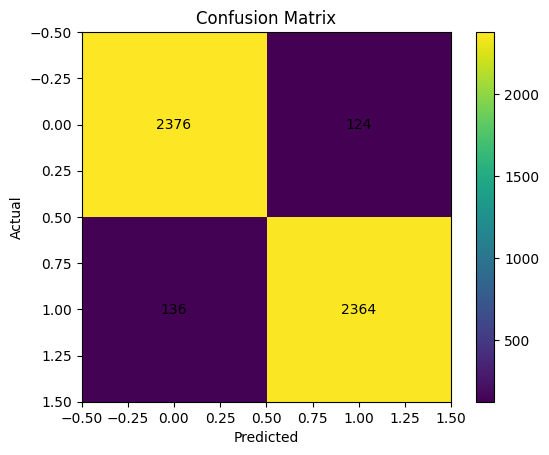

In [29]:
xgboost2_predict(Claude_shuffled.url , Claude_shuffled.label)